In [17]:
from seagul.rl.ars.ars_pipe2 import ARSAgent
from seagul.plot import smooth_bounded_curve
import seagul.envs

import os
import pickle
import torch
import gym
import numpy as np 
import matplotlib.pyplot as plt

env_name = "bball3-v0"

def do_rollout_ars(policy):
    torch.autograd.set_grad_enabled(False)
    env = gym.make(env_name, **env_config)
    obs = env.reset()

    obs = torch.as_tensor(obs, dtype=torch.float32)

    acts_list = []
    obs1_list = []
    rews_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    while not done:
        acts = policy(obs)
        obs, rew, done, out = env.step(acts)
          
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)

    torch.autograd.set_grad_enabled(True)
    return ep_obs1, ep_acts, ep_rews

In [24]:
trial_path = "/home/sgillen/work/bball/data_ars_wc/exp2"
agent_list = [] 
r_list = [] 

def reward_fn(state, action):
    xpen = np.clip(-(state[4] - .45)**2, -1, 0)
    #ypen = np.clip(-(state[5] - 2)**2, -1, 0)
    ypen = 0.0
    alive = 2.0
    return xpen + ypen + alive


for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        env_config = pickle.load(open(entry.path, 'rb'))
        continue
        
    agent_list.append(torch.load(entry.path))
    r_list.append(torch.stack(agent_list[-1].r_hist))

    
env = gym.make(env_name, **env_config)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1446c828d0>)

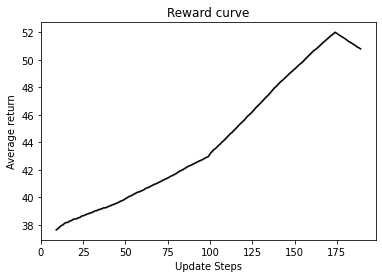

In [25]:
smooth_bounded_curve(torch.stack(r_list).T)

/home/sgillen/miniconda3/envs/matlab/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


reward sum: 31.275409698486328


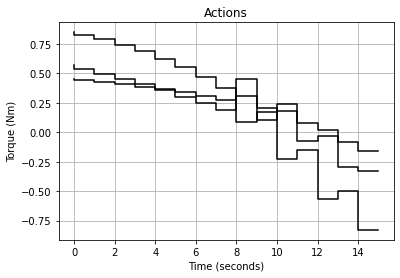

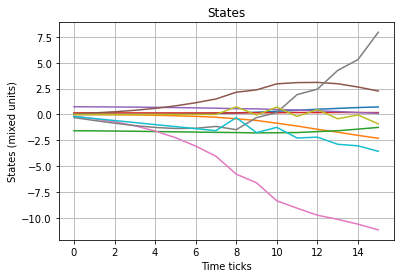

In [26]:
obs_hist, act_hist, rew_hist = do_rollout_ars(agent_list[0].policy)


print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('States (mixed units)')
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()

In [27]:
env.eng.clf()
obs_list = []
for o in obs:
    obs_list.append(o.tolist())
import matlab
tout = matlab.single([float(i) for i in range(obs.shape[0])])
env.animate(tout,matlab.single(obs_list))